
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [ ]:
!pip install d2l==1.0.0-beta0


# Kaggle で住宅価格を予測する

:label: `sec_kaggle_house`

深いネットワークを構築およびトレーニングし、重み減衰やドロップアウトなどの手法で正規化するための基本的なツールをいくつか導入しました。Kaggle コンテストに参加して、このすべての知識を実践する準備が整いました。住宅価格予測コンテストは始めるのに最適な場所です。データはかなり汎用的であり、(オーディオやビデオのように) 特殊なモデルを必要とするような特殊な構造は示されていません。このデータセットは :citet: `De-Cock.2011`によって収集され、2006 年から 2010 年の期間のアイオワ州エイムズの住宅価格をカバーしています。これは、Harrison と Rubinfeld (1978) による有名な[ボストンの住宅データセット](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names)よりもかなり大きく、より多くの例とより多くの機能を誇ります。

このセクションでは、データの前処理、モデル設計、ハイパーパラメーターの選択の詳細について説明します。実践的なアプローチを通じて、データ サイエンティストとしてのキャリアの指針となる直感を獲得していただければ幸いです。


In [1]:
%matplotlib inline
import numpy
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l


## データのダウンロード

この本全体を通じて、ダウンロードしたさまざまなデータセットでモデルをトレーニングし、テストします。ここでは、ファイルをダウンロードし、zip または tar ファイルを抽出するための**2 つのユーティリティ関数を実装します**。繰り返しますが、それらの実装は :numref: `sec_utils`に延期されます。


In [2]:
def download(url, folder, sha1_hash=None):
    """Download a file to folder and return the local filepath."""

def extract(filename, folder):
    """Extract a zip/tar file into folder."""


## カグル

[Kaggle は](https://www.kaggle.com)、機械学習コンテストを主催する人気のプラットフォームです。各コンテストはデータセットを中心としており、その多くは利害関係者によって後援され、優勝したソリューションに賞品を提供します。このプラットフォームは、ユーザーがフォーラムや共有コードを介して対話できるように支援し、コラボレーションと競争の両方を促進します。研究者が基本的な質問をするのではなく、近視眼的に前処理ステップに焦点を当てているため、リーダーボードの追跡は制御不能になることがよくありますが、競合するアプローチ間の直接の定量的比較やコード共有を容易にして誰もが何がうまくいき、何がうまくいかなかったかを学びます。 Kaggle コンテストに参加したい場合は、まずアカウントに登録する必要があります (:numref: `fig_kaggle`を参照)。

![](../img/kaggle.png) :幅: `400px` :ラベル: `fig_kaggle`

 :numref: `fig_house_pricing`に示すように、住宅価格予測コンテスト ページで、データセット ([データ] タブの下) を見つけ、予測を送信し、ランキングを確認できます。URL は次のとおりです。

>  https://www.kaggle.com/c/house-prices-advanced-regression-techniques 

![](../img/house-pricing.png) :幅: `400px` :ラベル: `fig_house_pricing`

## データセットへのアクセスと読み取り

競争データはトレーニング セットとテスト セットに分かれていることに注意してください。各レコードには、住宅の資産価値と、通りの種類、建設年、屋根の種類、地下室の状態などの属性が含まれます。特徴はさまざまなデータ タイプで構成されます。たとえば、建設年は整数で表され、屋根の種類は個別のカテゴリ割り当てで表され、その他の特徴は浮動小数点数で表されます。そして、現実が事態を複雑にしているのはここです。たとえば、一部のデータが完全に欠落しており、欠損値が単に「na」とマークされている場合があります。各ハウスの価格はトレーニングセットのみに含まれています（結局のところ、競争です）。トレーニング セットを分割して検証セットを作成したいと考えますが、Kaggle に予測をアップロードした後でのみ、公式のテスト セットでモデルを評価できるようになります。 :numref: `fig_house_pricing`のコンペティション タブの [データ] タブには、データをダウンロードするためのリンクがあります。

まず、 :numref: `sec_pandas`で導入した [ **`pandas`使用してデータを読み込んで処理**] します。便宜上、Kaggle ハウジング データセットをダウンロードしてキャッシュすることができます。このデータセットに対応するファイルがキャッシュ ディレクトリにすでに存在し、その SHA-1 が`sha1_hash`と一致する場合、コードはキャッシュされたファイルを使用して、冗長なダウンロードによるインターネットの詰まりを回避します。


In [3]:
class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))


トレーニング データセットには 1460 個の例、80 個の特徴、および 1 つのラベルが含まれており、検証データには 1459 個の例と 80 個の特徴が含まれています。


In [4]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)



## データの前処理

最初の 4 つの例から、[**最初の 4 つと最後の 2 つの機能とラベル (SalePrice) を見てみましょう**]。


In [5]:
print(data.raw_train.iloc[:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


各例で、最初の特徴は ID であることがわかります。これは、モデルが各トレーニング サンプルを識別するのに役立ちます。これは便利ですが、予測を目的とした情報は含まれません。したがって、データをモデルにフィードする前に、データセットからそれを削除します。さらに、さまざまなデータ型があるため、モデリングを開始する前にデータを前処理する必要があります。

まずは数値的な特徴から見ていきましょう。まず、ヒューリスティック [**すべての欠損値を対応する特徴の平均値で置き換える] を適用します。** ] 次に、すべての特徴を共通のスケールに置くために、(特徴をゼロ平均と単位分散に再スケーリングすることでデータを***標準化**):

 $$x \leftarrow \frac{x - \mu}{\sigma},$$

ここで、$\mu$ と $\sigma$ はそれぞれ平均と標準偏差を示します。これにより実際に特徴 (変数) が平均と単位分散がゼロになるように変換されることを確認するには、 $E[\frac{x-\mu}{\sigma}] = \frac{\mu - \mu}{ に注意してください。 \sigma} = 0$ であり、$E[(x-\mu)^2] = (\sigma^2 + \mu^2) - 2\mu^2+\mu^2 = \sigma^2$ となります。直感的に、データを標準化する理由は 2 つあります。まず、最適化に便利であることがわかります。第 2 に、どの特徴が関連するか*先験的*にはわからないため、ある特徴に割り当てられた係数に他の特徴よりも多くのペナルティを与えたくありません。

 [**次に、離散値を扱います。** ] これには、「MSZoning」などの機能が含まれます。以前にマルチクラス ラベルをベクトルに変換したのと同じ方法で ( :numref: `subsec_classification-problem`を参照) **、ワンホット エンコーディングで置き換えます**。たとえば、「MSZoning」は値「RL」と「RM」を想定します。 「MSZoning」機能を削除し、2 つの新しいインジケーター機能「MSZoning_RL」および「MSZoning_RM」が 0 または 1 の値で作成されます。ワンホット エンコーディングによれば、「MSZoning」の元の値が「RL」の場合、「 MSZoning_RL" は 1、「MSZoning_RM」は 0 です`pandas`パッケージはこれを自動的に行います。


In [6]:
@d2l.add_to_class(KaggleHouse)
def preprocess(self):
    # Remove the ID and label columns
    label = 'SalePrice'
    features = pd.concat(
        (self.raw_train.drop(columns=['Id', label]),
         self.raw_val.drop(columns=['Id'])))
    # Standardize numerical columns
    numeric_features = features.dtypes[features.dtypes!='object'].index
    features[numeric_features] = features[numeric_features].apply(
        lambda x: (x - x.mean()) / (x.std()))
    # Replace NAN numerical features by 0
    features[numeric_features] = features[numeric_features].fillna(0)
    # Replace discrete features by one-hot encoding
    features = pd.get_dummies(features, dummy_na=True)
    # Save preprocessed features
    self.train = features[:self.raw_train.shape[0]].copy()
    self.train[label] = self.raw_train[label]
    self.val = features[self.raw_train.shape[0]:].copy()


この変換により、特徴量の数が 79 から 331 に増加していることがわかります (ID 列とラベル列を除く)。


In [7]:
data.preprocess()
data.train.shape

(1460, 332)


## エラー対策

まず、二乗損失を使用して線形モデルをトレーニングします。当然のことですが、私たちの線形モデルはコンテストで優勝する提出物にはつながりませんが、データに意味のある情報が含まれているかどうかを確認する健全性チェックを提供します。ここでランダムな推測以外の方法ができない場合は、データ処理のバグがある可能性が高くなります。そして、うまくいけば、線形モデルはベースラインとして機能し、単純なモデルが報告されている最も優れたモデルにどの程度近づいているかを直感的に知ることができ、より複雑なモデルからどの程度の利益が期待できるかを知ることができます。

住宅価格についても、株価と同様に、絶対量よりも相対量を重視します。したがって、[**私たちは絶対誤差 $y - \hat{y}$ よりも相対誤差 $\frac{y - \hat{y}}{y}$ を気にする傾向があります**。たとえば、一般的な住宅の価格が 125,000 米ドルであるオハイオ州の田舎の住宅の価格を見積もるときに、予測が 100,000 米ドル外れた場合、おそらくひどい仕事をしていることになります。一方、カリフォルニア州ロスアルトスヒルズでこの程度の誤差があったとしても、これは驚くほど正確な予測を示している可能性があります (そこでは住宅価格の中央値が 400 万ドルを超えています)。

 (**この問題に対処する 1 つの方法は、価格推定値の対数の不一致を測定することです。** ) 実際、これは、コンテストが応募作品の品質を評価するために使用する公式の誤差尺度でもあります。結局のところ、$|\log y - \log \hat{y}| の小さな値 $\delta$ は、 \leq \delta$ は $e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$ に変換されます。これにより、予測価格の対数とラベル価格の対数の間に次の二乗平均平方根誤差が生じます。

 $$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$


In [8]:
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(numpy.array(x.values.tolist()), dtype=torch.float32)
    # Logarithm of prices
    tensors = (get_tensor(data.drop(columns=[label])),  # X
               torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
    return self.get_tensorloader(tensors, train)


## $K$ フォールド相互検証

:numref: `subsec_generalization-model-selection`で [ **cross-validation** ] を導入し、モデル選択の処理方法について説明したことを覚えているかもしれません。これをモデル設計の選択とハイパーパラメータの調整に活用します。まず、$K$ 倍交差検証手順でデータの $i^\mathrm{th}$ 倍を返す関数が必要です。 $i^\mathrm{th}$ セグメントを検証データとしてスライスし、残りをトレーニング データとして返すことによって続行されます。これはデータを処理する最も効率的な方法ではないことに注意してください。データセットがかなり大きい場合は、間違いなくもっと賢い方法を行うでしょう。ただし、この複雑さの追加によってコードが不必要に難読化される可能性があるため、問題が単純であるため、ここでは安全に省略できます。


In [9]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets


$K$ 分割交差検証で $K$ 回トレーニングすると、[**平均検証誤差が返されます**]。


In [10]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models


## 【**機種選定について**】

この例では、調整されていないハイパーパラメータのセットを選択し、モデルを改善するかどうかは読者に任せます。最適化する変数の数によっては、適切な選択肢を見つけるのに時間がかかる場合があります。十分な大きさのデータセットと通常の種類のハイパーパラメータを使用すると、$K$ 倍の相互検証は複数のテストに対して適度な回復力を示す傾向があります。ただし、不当に多数のオプションを試した場合、幸運に恵まれて、検証パフォーマンスが真のエラーを表わしていないことが判明する可能性があります。


average validation log mse = 0.17563143908977508


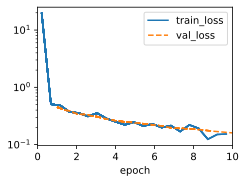

In [11]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.01)


$K$ 分割交差検証のエラー数がかなり多い場合でも、ハイパーパラメーターのセットのトレーニング エラーの数が非常に少ない場合があることに注意してください。これは、過剰適合していることを示しています。トレーニング中は両方の数値を監視する必要があります。過剰適合が少ないということは、データがより強力なモデルをサポートできることを示している可能性があります。大規模な過学習は、正則化手法を組み込むことで改善できることを示唆している可能性があります。

##  [ **Kaggle への予測の送信**]

ハイパーパラメータの適切な選択がわかったので、すべての $K$ モデルによって設定されたテストの平均予測を計算します。予測を CSV ファイルに保存すると、結果を Kaggle にアップロードすることが簡単になります。次のコードは、 `submission.csv`というファイルを生成します。


In [12]:
preds = [model(torch.tensor(numpy.array(data.val.values.tolist()), dtype=torch.float32))
         for model in models]
# Taking exponentiation of predictions in the logarithm scale
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame({'Id':data.raw_val.Id,
                           'SalePrice':ensemble_preds.detach().numpy()})
submission.to_csv('submission.csv', index=False)


次に、 :numref: `fig_kaggle_submit2`で示されているように、Kaggle で予測を送信し、テスト セット上の実際の住宅価格 (ラベル) とどのように比較するかを確認できます。手順は非常に簡単です。
-  Kaggle Web サイトにログインし、住宅価格予測コンテストのページにアクセスします。
-  「予測を送信」または「遅延送信」ボタンをクリックします (この記事の執筆時点では、ボタンは右側にあります)。
- ページの下部にある破線のボックスにある [提出ファイルをアップロード] ボタンをクリックし、アップロードする予測ファイルを選択します。
- ページの下部にある「送信」ボタンをクリックして結果を表示します。

![](../img/kaggle-submit2.png) :幅: `400px` :ラベル: `fig_kaggle_submit2`

## まとめ

実際のデータにはさまざまなデータ型が混在していることが多く、前​​処理が必要です。実数値データをゼロ平均と単位分散に再スケーリングするのが適切なデフォルトです。欠損値を平均値に置き換える場合も同様です。さらに、カテゴリ特徴をインジケータ特徴に変換すると、それらをワンホット ベクトルのように扱うことができます。絶対誤差よりも相対誤差を気にする傾向がある場合は、予測の対数の不一致を測定できます。モデルを選択してハイパーパラメーターを調整するには、 $K$ 分割交差検証を使用できます。

## 演習
1. このセクションの予測を Kaggle に送信してください。あなたの予測はどれくらい当たっていますか？
1. 欠損値をその平均値で置き換えることは常に良い考えでしょうか?ヒント: 値がランダムに欠落しない状況を構築できますか?
1.  $K$ 分割交差検証を通じてハイパーパラメータを調整することで、Kaggle のスコアを改善します。
1. モデル (レイヤー、重み減衰、ドロップアウトなど) を改善することでスコアを改善します。
1. このセクションで行ったように連続数値特徴を標準化しない場合はどうなるでしょうか?



[ディスカッション](https://discuss.d2l.ai/t/107)
